# Project

### Import Libraries

In [1]:
!pip install matplotlib basemap kagglehub mlcroissant

Download From Google Drive or via **mlcroissant** (preferred)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_to_dataset = "/content/drive/MyDrive/global_terrorism.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import plotly.graph_objects as go
import plotly.express as px
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import networkx as nx
from scipy.stats import ttest_ind, f_oneway

### Load and Inspect Data

In [51]:
df = pd.read_csv(path_to_dataset, encoding="ISO-8859-1")

df.head()

<ipython-input-51-1996d58ea7e1>:1: DtypeWarning:

Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.



eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...      NaN    NaN    NaN     NaN      PGIS   
1              Mexico       1  ...      NaN    NaN    NaN     NaN      PGIS   
2         Philippines       5  ...      NaN    NaN    NaN     NaN      PGIS   
3              Greece       8  ...      NaN    NaN    NaN     NaN      PGIS   
4               Japan       4  ...      NaN    NaN    NaN     NaN      PGIS   

   INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0        0         0        0       0      NaN  
1        0         1        1       1      NaN  
2       -9        -9        1       1      NaN  
3       -9        -9        1       1      NaN  
4       -9        -9        1       1      NaN  

[5 rows x 135 columns]

In [5]:
print(df.describe())

            eventid          iyear         imonth           iday  \
count  1.816910e+05  181691.000000  181691.000000  181691.000000   
mean   2.002705e+11    2002.638997       6.467277      15.505644   
std    1.325957e+09      13.259430       3.388303       8.814045   
min    1.970000e+11    1970.000000       0.000000       0.000000   
25%    1.991021e+11    1991.000000       4.000000       8.000000   
50%    2.009022e+11    2009.000000       6.000000      15.000000   
75%    2.014081e+11    2014.000000       9.000000      23.000000   
max    2.017123e+11    2017.000000      12.000000      31.000000   

            extended        country         region       latitude  \
count  181691.000000  181691.000000  181691.000000  177135.000000   
mean        0.045346     131.968501       7.160938      23.498343   
std         0.208063     112.414535       2.933408      18.569242   
min         0.000000       4.000000       1.000000     -53.154613   
25%         0.000000      78.000000       

In [6]:
print(df.isnull().sum())

eventid            0
iyear              0
imonth             0
iday               0
approxdate    172452
               ...  
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
related       156653
Length: 135, dtype: int64


## Data Preprocessing
### Select Relevant Columns
We will select only the columns that are essential for our analysis.

In [7]:
df = df[["iyear", "imonth", "country_txt", "region_txt", "latitude", "longitude", "success", "attacktype1_txt", "targtype1_txt", "natlty1_txt", "gname", "weaptype1_txt", "nkill", "nwound"]]

### Rename Columns
For better readability, we will rename the columns.

In [8]:
df = df.rename(columns={
    "iyear": "Year",
    "imonth": "Month",
    "country_txt": "Country",
    "region_txt": "Region",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "success": "Success_Status",
    "attacktype1_txt": "Attack_Type",
    "targtype1_txt": "Target_Type",
    "natlty1_txt": "Nationality",
    "gname": "Group_Name",
    "weaptype1_txt": "Weapon_Type",
    "nkill": "Num_Killed",
    "nwound": "Num_Wounded"
})

In [9]:
print(df.isnull().sum())

Year                  0
Month                 0
Country               0
Region                0
Latitude           4556
Longitude          4557
Success_Status        0
Attack_Type           0
Target_Type           0
Nationality        1559
Group_Name            0
Weapon_Type           0
Num_Killed        10313
Num_Wounded       16311
dtype: int64


### Handle Missing Values
We will handle missing values by filling them with appropriate default values.

In [10]:
df['Latitude'] = df['Latitude'].fillna(0)
df['Longitude'] = df['Longitude'].fillna(0)
df['Nationality'] = df['Nationality'].fillna('Unknown')
df['Group_Name'] = df['Group_Name'].fillna('Unknown')
df['Weapon_Type'] = df['Weapon_Type'].fillna('Unknown')
df['Num_Killed'] = df['Num_Killed'].fillna(0)
df['Num_Wounded'] = df['Num_Wounded'].fillna(0)

In [11]:
df['Weapon_Type'] = df['Weapon_Type'].apply(lambda x: 'Vehicle' if x == 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)' else x)

### Data Type Conversion
Convert columns to appropriate data types.

In [12]:
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)
df['Country'] = df['Country'].astype(str)
df['Region'] = df['Region'].astype(str)
df['Attack_Type'] = df['Attack_Type'].astype(str)
df['Target_Type'] = df['Target_Type'].astype(str)
df['Nationality'] = df['Nationality'].astype(str)
df['Group_Name'] = df['Group_Name'].astype(str)
df['Weapon_Type'] = df['Weapon_Type'].astype(str)
df['Num_Killed'] = df['Num_Killed'].astype(int)
df['Num_Wounded'] = df['Num_Wounded'].astype(int)

In [13]:
print(df[['Num_Killed', 'Num_Wounded']].describe())

          Num_Killed    Num_Wounded
count  181691.000000  181691.000000
mean        2.266860       2.883291
std        11.227057      34.309746
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         2.000000       2.000000
max      1570.000000    8191.000000


### Feature Engineering
Create a new column for total casualties.

In [14]:
df['Total_Casualties'] = df['Num_Killed'] + df['Num_Wounded']

In [15]:
df.head()

Year  Month             Country                       Region   Latitude  \
0  1970      7  Dominican Republic  Central America & Caribbean  18.456792   
1  1970      0              Mexico                North America  19.371887   
2  1970      1         Philippines               Southeast Asia  15.478598   
3  1970      1              Greece               Western Europe  37.997490   
4  1970      1               Japan                    East Asia  33.580412   

    Longitude  Success_Status                     Attack_Type  \
0  -69.951164               1                   Assassination   
1  -99.086624               1     Hostage Taking (Kidnapping)   
2  120.599741               1                   Assassination   
3   23.762728               1               Bombing/Explosion   
4  130.396361               1  Facility/Infrastructure Attack   

                   Target_Type         Nationality  \
0  Private Citizens & Property  Dominican Republic   
1      Government (Diplomatic)             Belgium   
2          Journalists & Media       United States   
3      Government (Diplomatic)       United States   
4      Government (Diplomatic)       United States   

                           Group_Name Weapon_Type  Num_Killed  Num_Wounded  \
0                              MANO-D     Unknown           1            0   
1  23rd of September Communist League     Unknown           0            0   
2                             Unknown     Unknown           1            0   
3                             Unknown  Explosives           0            0   
4                             Unknown  Incendiary           0            0   

   Total_Casualties  
0                 1  
1                 0  
2                 1  
3                 0  
4                 0

In [16]:
print(df.columns.tolist())

['Year', 'Month', 'Country', 'Region', 'Latitude', 'Longitude', 'Success_Status', 'Attack_Type', 'Target_Type', 'Nationality', 'Group_Name', 'Weapon_Type', 'Num_Killed', 'Num_Wounded', 'Total_Casualties']


## Exploratory Data Analysis


### Dataset Overview

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              181691 non-null  int64  
 1   Month             181691 non-null  int64  
 2   Country           181691 non-null  object 
 3   Region            181691 non-null  object 
 4   Latitude          181691 non-null  float64
 5   Longitude         181691 non-null  float64
 6   Success_Status    181691 non-null  int64  
 7   Attack_Type       181691 non-null  object 
 8   Target_Type       181691 non-null  object 
 9   Nationality       181691 non-null  object 
 10  Group_Name        181691 non-null  object 
 11  Weapon_Type       181691 non-null  object 
 12  Num_Killed        181691 non-null  int64  
 13  Num_Wounded       181691 non-null  int64  
 14  Total_Casualties  181691 non-null  int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 20.8+ MB


### Statistical Summary

In [18]:
df.describe()

Year          Month       Latitude     Longitude  \
count  181691.000000  181691.000000  181691.000000  1.816910e+05   
mean     2002.638997       6.467277      22.909109 -4.471911e+02   
std        13.259430       3.388303      18.699442  2.021946e+05   
min      1970.000000       0.000000     -53.154613 -8.618590e+07   
25%      1991.000000       4.000000       9.518645  1.231572e+00   
50%      2009.000000       6.000000      31.126646  4.314357e+01   
75%      2014.000000       9.000000      34.538561  6.835734e+01   
max      2017.000000      12.000000      74.633553  1.793667e+02   

       Success_Status     Num_Killed    Num_Wounded  Total_Casualties  
count   181691.000000  181691.000000  181691.000000     181691.000000  
mean         0.889598       2.266860       2.883291          5.150151  
std          0.313391      11.227057      34.309746         40.555414  
min          0.000000       0.000000       0.000000          0.000000  
25%          1.000000       0.000000       0.000000          0.000000  
50%          1.000000       0.000000       0.000000          1.000000  
75%          1.000000       2.000000       2.000000          4.000000  
max          1.000000    1570.000000    8191.000000       9574.000000

Missing Values

In [19]:
print(df.isnull().sum())

Year                0
Month               0
Country             0
Region              0
Latitude            0
Longitude           0
Success_Status      0
Attack_Type         0
Target_Type         0
Nationality         0
Group_Name          0
Weapon_Type         0
Num_Killed          0
Num_Wounded         0
Total_Casualties    0
dtype: int64


First 5 Rows of Dataset

In [50]:
df.head(5)

Year  Month             Country                       Region   Latitude  \
0  1970      7  Dominican Republic  Central America & Caribbean  18.456792   
1  1970      0              Mexico                North America  19.371887   
2  1970      1         Philippines               Southeast Asia  15.478598   
3  1970      1              Greece               Western Europe  37.997490   
4  1970      1               Japan                    East Asia  33.580412   

    Longitude  Success_Status                     Attack_Type  \
0  -69.951164               1                   Assassination   
1  -99.086624               1     Hostage Taking (Kidnapping)   
2  120.599741               1                   Assassination   
3   23.762728               1               Bombing/Explosion   
4  130.396361               1  Facility/Infrastructure Attack   

                   Target_Type         Nationality  \
0  Private Citizens & Property  Dominican Republic   
1      Government (Diplomatic)             Belgium   
2          Journalists & Media       United States   
3      Government (Diplomatic)       United States   
4      Government (Diplomatic)       United States   

                           Group_Name Weapon_Type  Num_Killed  Num_Wounded  \
0                              MANO-D     Unknown           1            0   
1  23rd of September Communist League     Unknown           0            0   
2                             Unknown     Unknown           1            0   
3                             Unknown  Explosives           0            0   
4                             Unknown  Incendiary           0            0   

   Total_Casualties  
0                 1  
1                 0  
2                 1  
3                 0  
4                 0

In [21]:
df = df.drop_duplicates()

### Value Counts of Categorical Variables


In [22]:
categorical_columns = ['Country', 'Region', 'Success_Status', 'Attack_Type', 'Target_Type', 'Nationality', 'Group_Name', 'Weapon_Type']

for col in categorical_columns:
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts())



Value Counts for Country:
Country
Iraq                   21047
Pakistan               13085
Afghanistan            12385
India                  11362
Colombia                7177
                       ...  
South Vietnam              1
New Hebrides               1
Falkland Islands           1
Antigua and Barbuda        1
North Korea                1
Name: count, Length: 205, dtype: int64

Value Counts for Region:
Region
Middle East & North Africa     45033
South Asia                     42257
Sub-Saharan Africa             16514
South America                  15348
Western Europe                 14235
Southeast Asia                 11699
Central America & Caribbean     8460
Eastern Europe                  4841
North America                   3137
East Asia                        668
Central Asia                     543
Australasia & Oceania            265
Name: count, dtype: int64

Value Counts for Success_Status:
Success_Status
1    144707
0     18293
Name: count, dtype: int64

Valu

## Visualizations
### Number of Events by Year

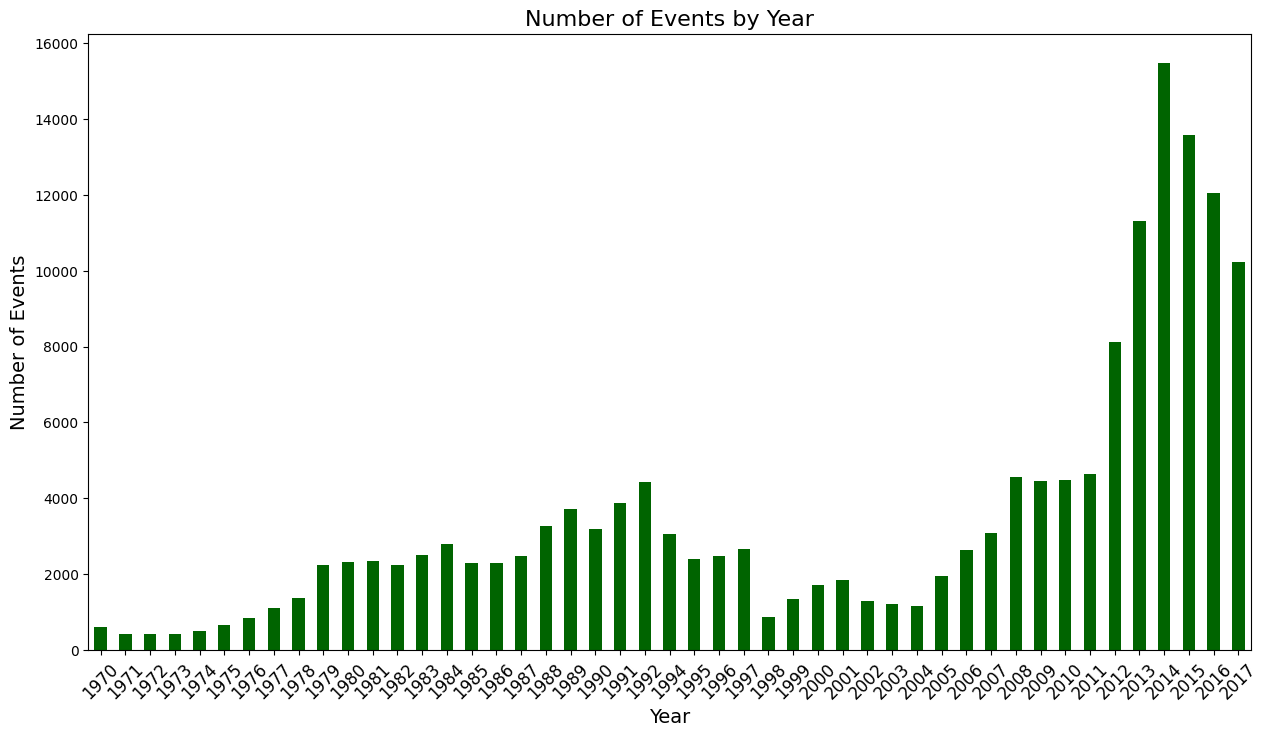

In [23]:
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 8), color='darkgreen')
plt.title("Number of Events by Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

### Top 10 Countries with Most Events

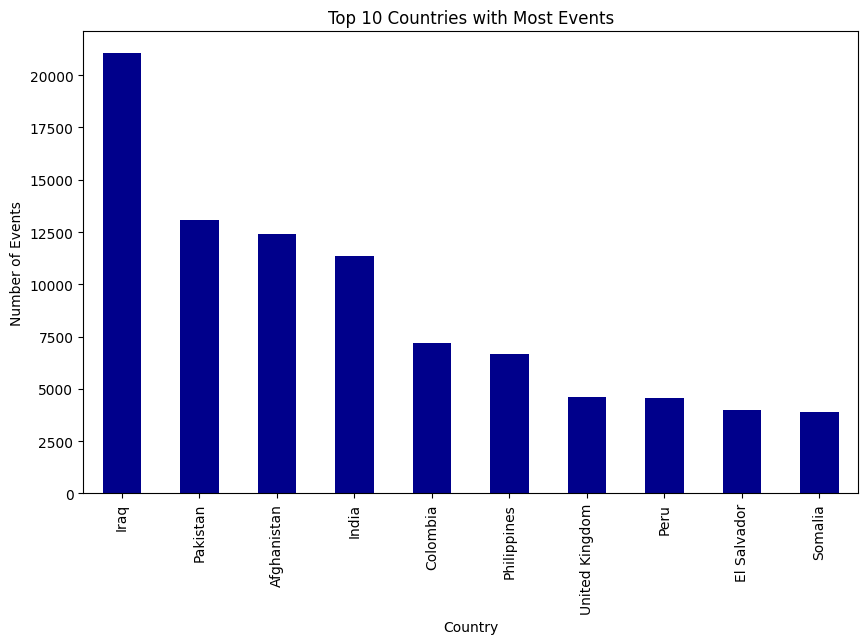

In [24]:
df['Country'].value_counts().head(10).plot(kind='bar', figsize=(10, 6), color="darkblue")
plt.title("Top 10 Countries with Most Events")
plt.xlabel("Country")
plt.ylabel("Number of Events")
plt.show()

### The pie chart below shows the proportion of each attack type, with the percentages labeled in the legend. The chart visually represents how each type of attack contributes to the total.

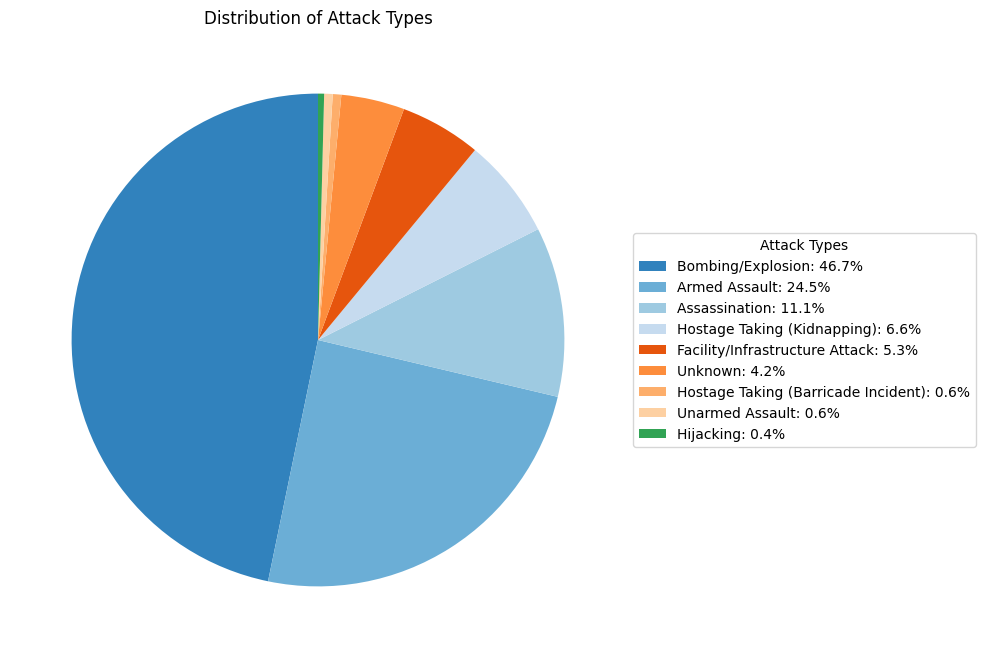

In [25]:
attack_types = df['Attack_Type'].value_counts()
percentages = (attack_types / attack_types.sum() * 100).round(1)
plt.figure(figsize=(10, 8))
wedges, texts = plt.pie(
    attack_types,
    startangle=90,
    colors=plt.cm.tab20c.colors
)
legend_labels = [f"{label}: {percent}%" for label, percent in zip(attack_types.index, percentages)]
plt.legend(
    wedges,
    legend_labels,
    title="Attack Types",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribution of Attack Types')
plt.ylabel('')

plt.show()

### The graph below shows the total number of casualties (killed and wounded) by region. The stacked bar chart represents the number of people killed and wounded in each region, with the height of each bar indicating the total number of casualties. The number of casualties for each category is labeled on the bars.

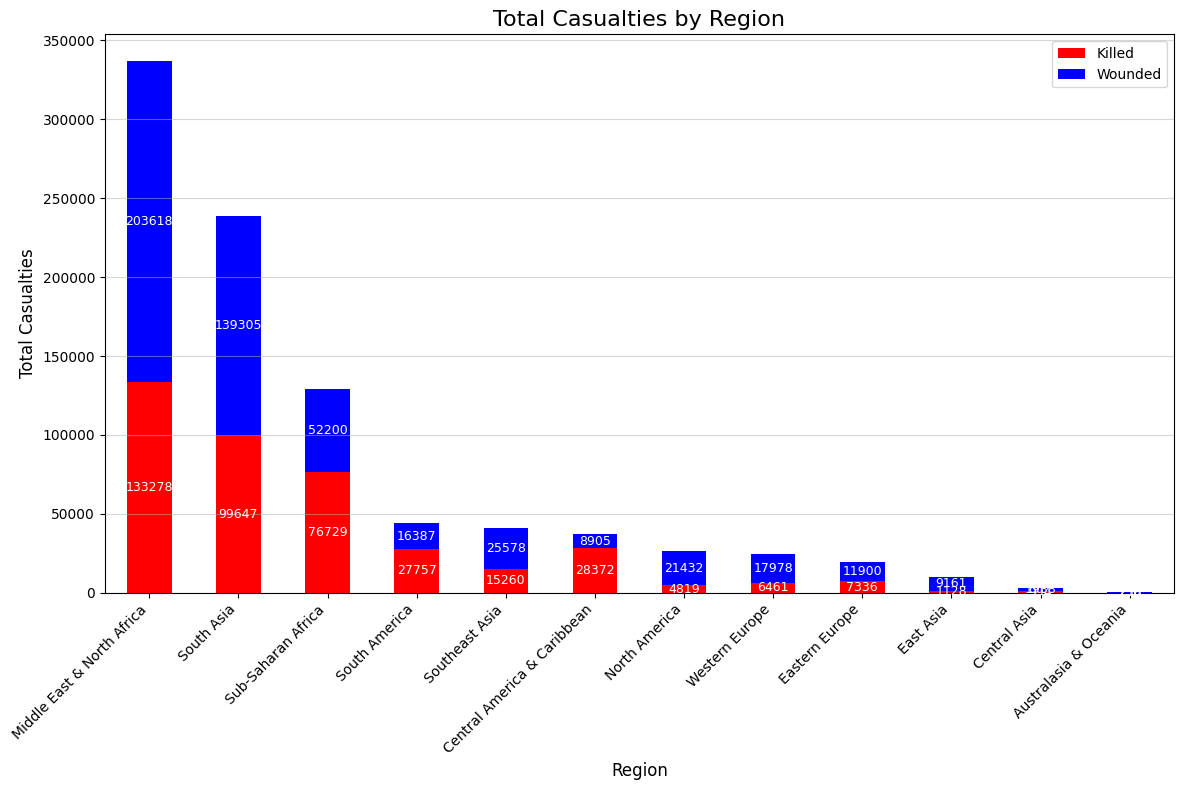

In [38]:
region_casualties = df.groupby('Region')[['Num_Killed', 'Num_Wounded']].sum()
region_casualties['Total_Casualties'] = region_casualties['Num_Killed'] + region_casualties['Num_Wounded']
region_casualties = region_casualties.sort_values(by='Total_Casualties', ascending=False)
region_casualties = region_casualties.drop(columns=['Total_Casualties'])

ax = region_casualties.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=['red', 'blue']
)

for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{int(height)}',
                ha='center', va='center', fontsize=9, color='white'
            )

plt.title("Total Casualties by Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Total Casualties", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(['Killed', 'Wounded'], fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

plt.show()

### The graph below shows the yearly trends in casualties, with separate lines representing the number of people killed and wounded each year.

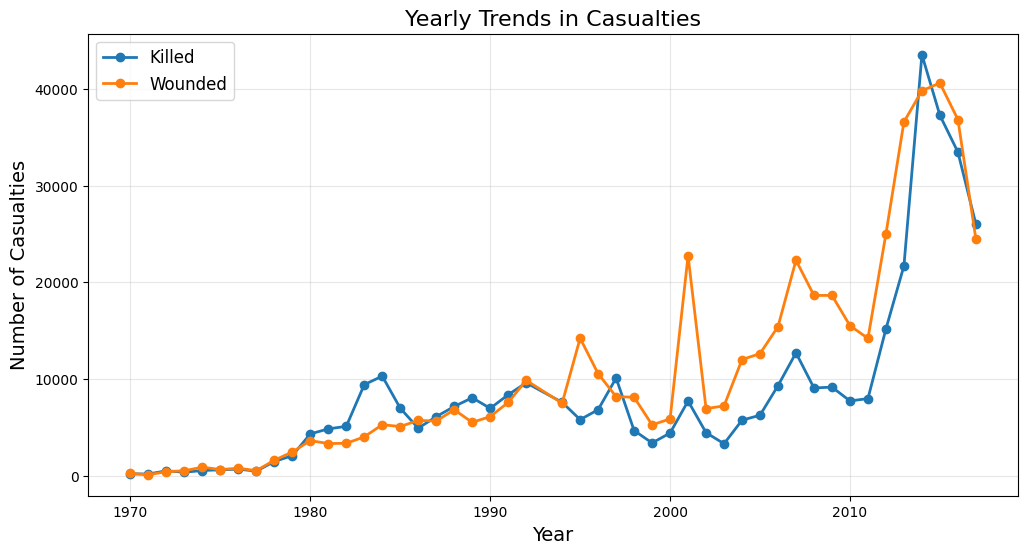

In [27]:
yearly_casualties = df.groupby('Year')[['Num_Killed', 'Num_Wounded']].sum()
plt.figure(figsize=(12, 6))
yearly_casualties.plot(kind='line', linewidth=2, marker='o', ax=plt.gca())
plt.title('Yearly Trends in Casualties', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Casualties', fontsize=14)
plt.legend(['Killed', 'Wounded'], fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [28]:
df_grouped = df.groupby(['Year', 'Region', 'Attack_Type']).size().reset_index(name='Count')

### This chart displays the number of attacks by year, categorized by attack type and region. It allows users to observe the trend in attack counts for each type over time, with animation by year.

In [29]:
fig = px.bar(
    df_grouped,
    x='Year',
    y='Count',
    color='Region',
    animation_frame='Attack_Type',
    # text='Count',
    title='Attack Type by Year',
    labels={'Count': 'Number of Attacks', 'Year': 'Year'},
)
fig.update_layout(
    barmode='stack',
    title={
        'text': 'Attack Type by Year',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis=dict(title='Year', tickmode='linear'),
    yaxis=dict(title='Number of Attacks'),
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500

for frame in fig.frames:
    frame.layout = {"yaxis": {"autorange": True}}

fig.show()

### Below is a world map showing the geographical locations of attacks, categorized by attack type. The animation by year allows you to observe how attacks are distributed globally over time.


In [30]:
fig = px.scatter_geo(
    df,
    lat='Latitude',
    lon='Longitude',
    color='Attack_Type',
    animation_frame='Year',
    title='Attacks Around the World',
    projection='natural earth',
    labels={'Attack_Type': 'Type of Attack'},
)

fig.update_layout(
    title={
        'text': "Attacks Around the World",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    geo=dict(
        showcoastlines=True,
        coastlinecolor="LightGray",
        showland=True,
        landcolor="whitesmoke",
        showocean=True,
        oceancolor="lightblue"
    )
)

fig.update_geos(showcoastlines=True, coastlinecolor="LightGray",
                showland=True, landcolor="whitesmoke",
                showocean=True, oceancolor="lightblue")
fig.show()

### The treemap below visualizes the distribution of attack types by region. Each region is represented by a section, and the attack types are displayed as sub-sections within those regions.

In [31]:
fig = px.treemap(
    df_grouped,
    path=['Region', 'Attack_Type'],
    values='Count',
    title="Treemap Diagram: Attack Types by Region",
    color='Region',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(title={'x': 0.5, 'xanchor': 'center'})
fig.show()

# **Hypothesis: The frequency of choosing a particular weapon depends on the average number of victims**

**Analysis Approach**

---

1. Description of the data used
2. Testing for a linear relationship between the popularity of weapons and the number of victims
3. Statistical test
4. Comparison of data on a single graph
5. Interpretation of results
6. Conclusion


For the analysis we will use the total number of deaths and victims to analyze the hypothesis

In [32]:
df['Total_Casualties'] = df['Num_Killed'] + df['Num_Wounded']

Grouping by weapon type

In [33]:
weapon_stats = df.groupby('Weapon_Type').agg(
    avg_casualties=('Total_Casualties', 'mean'),
    usage_count=('Weapon_Type', 'count')
)

<ipython-input-39-0d733cfaeb3f>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




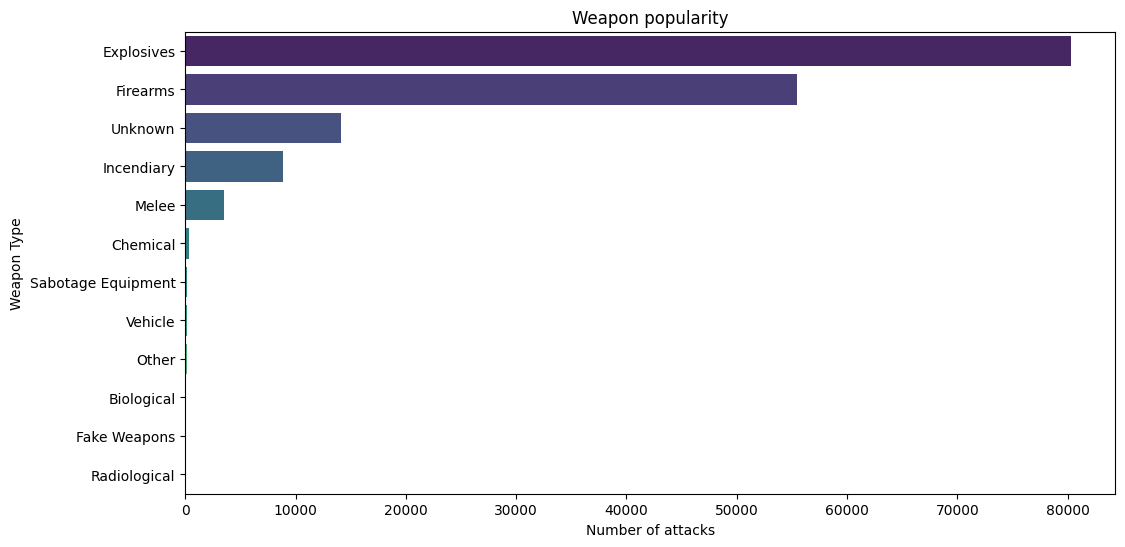

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Weapon_Type', order=df['Weapon_Type'].value_counts().index, palette='viridis')
plt.title('Weapon popularity')
plt.xlabel('Number of attacks')
plt.ylabel('Weapon Type')
plt.show()

Dependencies Research

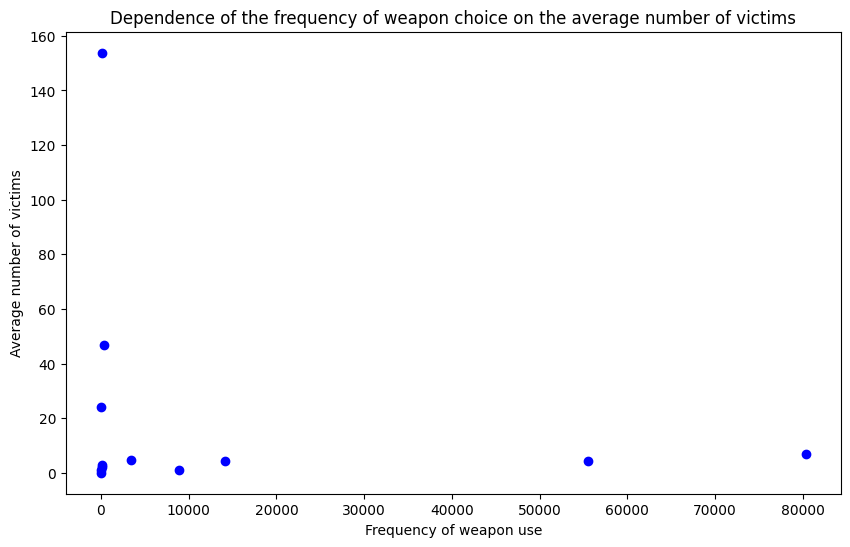

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(weapon_stats['usage_count'], weapon_stats['avg_casualties'], color='blue')
plt.title('Dependence of the frequency of weapon choice on the average number of victims')
plt.xlabel('Frequency of weapon use')
plt.ylabel('Average number of victims')
plt.show()

The correlation between weapon choice and number of victims is close to 0

In [42]:
correlation = weapon_stats['usage_count'].corr(weapon_stats['avg_casualties'])
print(f"The correlation: {correlation}")

The correlation: -0.19736769252964015


Statistical test

In [44]:
high_usage = weapon_stats[weapon_stats['usage_count'] > weapon_stats['usage_count'].median()]
low_usage = weapon_stats[weapon_stats['usage_count'] <= weapon_stats['usage_count'].median()]

t_stat, p_value = ttest_ind(high_usage['avg_casualties'], low_usage['avg_casualties'])

print(f"p-value: {p_value}")

p-value: 0.47390188204651995


The p-value (probability of observing the given data, assuming the null hypothesis is true) is large enough to suggest that there is insufficient evidence to reject the null hypothesis. In other words, the data does not show a significant difference between the groups, leading us to conclude that the hypothesis is not supported by the evidence.

Final dependence graph

<ipython-input-46-428be6ed7bb1>:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



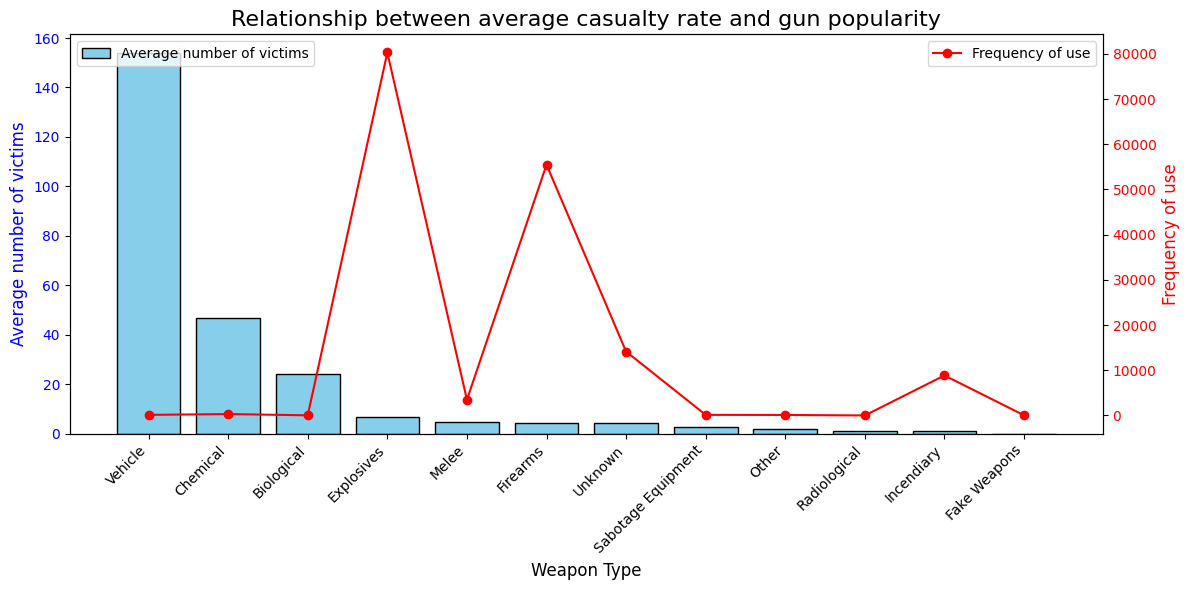

In [46]:
weapon_stats = df.groupby('Weapon_Type').agg(
    avg_casualties=('Total_Casualties', 'mean'),
    usage_count=('Weapon_Type', 'count')
).sort_values(by='avg_casualties', ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(weapon_stats.index, weapon_stats['avg_casualties'], color='skyblue', edgecolor='black', label='Average number of victims')
ax1.set_xlabel('Weapon Type', fontsize=12)
ax1.set_ylabel('Average number of victims', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(weapon_stats.index, rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(weapon_stats.index, weapon_stats['usage_count'], color='red', marker='o', label='Frequency of use')
ax2.set_ylabel('Frequency of use', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Relationship between average casualty rate and gun popularity', fontsize=16)
fig.tight_layout()
plt.show()

A detailed comparison of the most deadly weapons and the most popular

In [47]:
vehicle_count = df['Weapon_Type'].value_counts().get('Vehicle', 0)
print(f"Vehicle was used {vehicle_count} times.")


vehicle_deaths = df[df['Weapon_Type'] == 'Vehicle']['Total_Casualties'].sum()

print(f"Total deaths by vehicle: {vehicle_deaths}")

Vehicle was used 132 times.
Total deaths by vehicle: 20302


In [48]:
explosives_count = df['Weapon_Type'].value_counts().get('Explosives', 0)

print(f"Explosives were used {explosives_count} times.")

explosives_deaths = df[df['Weapon_Type'] == 'Explosives']['Total_Casualties'].sum()

print(f"Total deaths by explosives: {explosives_deaths}")

Explosives were used 80308 times.
Total deaths by explosives: 542030


The average number of victims refutes the hypothesis put forward

In [49]:
print(vehicle_deaths / vehicle_count)
print(explosives_deaths / explosives_count)

153.8030303030303
6.749389849081038


**Interpretation**
* Correlation close to 0
* P value of statistical test
* dependency graphs
* detailed analysis of the obtained data

**refute** the initially proposed hypothesis.

## **Conclusion**

Based on the analysis, the hypothesis that the choice of weapon depends on the average statistical number of victims was refuted. The null hypothesis, which asserts the independence of these variables, could not be rejected. This means that the frequency of choosing a weapon does not depend on the number of victims in terrorist attacks. Therefore, the choice of weapon is most likely determined by other factors that require additional research.
